<a href="https://colab.research.google.com/github/CAPP30255-Project/DepressionDetection/blob/master/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
ROOT = '/content/drive'
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import sys
from os.path import join 
repo_dir = '/content/drive/MyDrive/Repos/DepressionDetection'

In [3]:
data_dir = repo_dir + '/data/Suicide_Detection.csv'

In [4]:
%cd "{repo_dir}"
#%pip install -r jj_dt_project_requirements.txt

/content/drive/MyDrive/Repos/DepressionDetection


In [5]:
#!pip install torchtext==0.12.0

In [8]:
!git pull

Already up to date.


In [5]:
from data.data_process import *
from _core.bow_classifier import *
#import nltk
#nltk.download('punkt')


# Bow Split

In [ ]:
depression_data = dep_data(data_dir, tokenizer = "split")

In [ ]:
depression_data.split_data(123)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [ ]:
depression_data.prep_bow_dataloaders(32)

At iteration 500 the loss is 0.656.
At iteration 1000 the loss is 0.628.
At iteration 1500 the loss is 0.584.
At iteration 2000 the loss is 0.539.
At iteration 2500 the loss is 0.588.
At iteration 3000 the loss is 0.517.
At iteration 3500 the loss is 0.536.
At iteration 4000 the loss is 0.537.

After epoch 1 the validation accuracy is 84.375.

At iteration 500 the loss is 0.476.
At iteration 1000 the loss is 0.467.
At iteration 1500 the loss is 0.437.
At iteration 2000 the loss is 0.383.
At iteration 2500 the loss is 0.501.
At iteration 3000 the loss is 0.415.
At iteration 3500 the loss is 0.444.
At iteration 4000 the loss is 0.462.

After epoch 2 the validation accuracy is 87.500.

At iteration 500 the loss is 0.390.
At iteration 1000 the loss is 0.389.
At iteration 1500 the loss is 0.376.
At iteration 2000 the loss is 0.313.
At iteration 2500 the loss is 0.461.
At iteration 3000 the loss is 0.369.
At iteration 3500 the loss is 0.393.
At iteration 4000 the loss is 0.416.

After epoch 

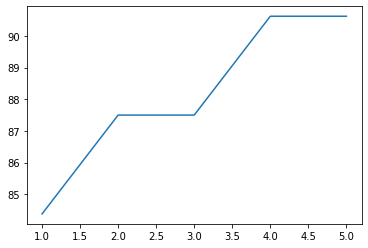

In [ ]:
train_BOW(depression_data, epochs = 5)

# BoW NLTK

In [8]:
depression_data = dep_data(data_dir, tokenizer = "NLTK")

In [9]:
depression_data.split_data(123)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [12]:
BATCH_SIZE = 128
using_GPU = True
EPOCHS = 5

vocab, counter = bow_classifier(depression_data.all_data)
train_dataloader = data_loader_bow(depression_data.train, vocab, BATCH_SIZE, shuffle = False)
test_dataloader = data_loader_bow(depression_data.test, vocab, BATCH_SIZE, shuffle = False)
val_dataloader = data_loader_bow(depression_data.val, vocab, BATCH_SIZE, shuffle = False)

Vocab Size =  1930
Vocab Size =  1930
Vocab Size =  1930


At iteration 500 the loss is 0.623.
At iteration 1000 the loss is 0.563.
New best model saved!

After epoch 1 the validation accuracy is 85.156.

At iteration 500 the loss is 0.518.
At iteration 1000 the loss is 0.485.
New best model saved!

After epoch 2 the validation accuracy is 88.281.

At iteration 500 the loss is 0.452.
At iteration 1000 the loss is 0.438.

After epoch 3 the validation accuracy is 88.281.

At iteration 500 the loss is 0.407.
At iteration 1000 the loss is 0.407.
New best model saved!

After epoch 4 the validation accuracy is 89.844.

At iteration 500 the loss is 0.375.
At iteration 1000 the loss is 0.387.
New best model saved!

After epoch 5 the validation accuracy is 91.406.



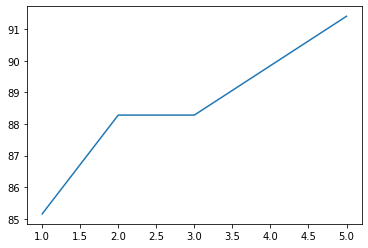

In [16]:
import matplotlib.pyplot as plt
EPOCHS = 5
torch.cuda.empty_cache()
model = BoWClassifier(vocab_size = 1930,
                      num_labels = 2)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.NLLLoss()
best_accuracy = 0
if using_GPU:
    model.cuda()
    loss_function.to('cuda')
accuracies=[]
for epoch in range(1, EPOCHS + 1):
    train_an_epoch(dataloader = train_dataloader,
                    model = model,
                    optimizer = optimizer, 
                    loss_fn=loss_function,
                    using_GPU = using_GPU)
    accuracy = get_accuracy(val_dataloader, model)
    if accuracy > best_accuracy:
            best_accuracy = accuracy
            with open("/content/drive/MyDrive/Repos/DepressionDetection/output/logistic_bow_NLTK_best.pt", 'wb') as f:
                torch.save(model, f)
                print("New best model saved!")
    
    accuracies.append(accuracy)
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

# Using GloVe Embeddings

In [25]:
depression_data = dep_data(data_dir, tokenizer = "split")
depression_data.split_data(123)

from torchtext import vocab

glove = vocab.GloVe('6B')

def bow_classifier2(data):
    counter = Counter()
    for (line, label) in data:
        counter.update(line)
    vocab = v(counter, specials = ['<unk>'], special_first = True, min_freq = 1000)
    return vocab, counter

from torchtext.vocab import vocab as v
vocab_words, counter = bow_classifier2(depression_data.all_data)
vocab_words.set_default_index(0)
glove_vector = glove.get_vecs_by_tokens(vocab_words.get_itos())

def collate_fn(batch):
    vectors = torch.zeros(len(batch), len(vocab_words))
    label_mapping = {'non-suicide': 0, 'suicide': 1}
    labels = []
    for index, example in enumerate(batch):
      indexes = vocab_words(example[0])
      for w_idx in indexes:
        vectors[index, int(w_idx)] = 1
      labels.append(label_mapping.get(example[1]))
    labels = torch.tensor(labels)
    return   labels.cuda(), vectors.cuda()

train_dataloader = DataLoader(depression_data.train, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
val_dataloader = DataLoader(depression_data.val, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(depression_data.test, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


At iteration 500 the loss is 0.258.
At iteration 1000 the loss is 0.170.
New best model saved!

After epoch 1 the validation accuracy is 96.875.

At iteration 500 the loss is 0.200.
At iteration 1000 the loss is 0.246.
New best model saved!

After epoch 2 the validation accuracy is 97.656.

At iteration 500 the loss is 0.208.
At iteration 1000 the loss is 0.224.

After epoch 3 the validation accuracy is 97.656.

At iteration 500 the loss is 0.292.
At iteration 1000 the loss is 0.204.

After epoch 4 the validation accuracy is 97.656.

At iteration 500 the loss is 0.361.
At iteration 1000 the loss is 0.240.

After epoch 5 the validation accuracy is 97.656.



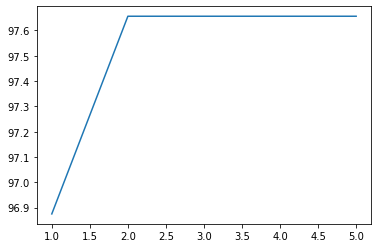

In [26]:
import matplotlib.pyplot as plt
EPOCHS = 5
torch.cuda.empty_cache()
model = BoWClassifier(vocab_size = len(vocab_words),
                      num_labels = 2)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.NLLLoss()
best_accuracy = 0
if using_GPU:
    model.cuda()
    loss_function.to('cuda')
accuracies=[]
for epoch in range(1, EPOCHS + 1):
    train_an_epoch(dataloader = train_dataloader,
                    model = model,
                    optimizer = optimizer, 
                    loss_fn=loss_function,
                    using_GPU = using_GPU)
    accuracy = get_accuracy(val_dataloader, model)
    if accuracy > best_accuracy:
            best_accuracy = accuracy
            with open("/content/drive/MyDrive/Repos/DepressionDetection/output/logistic_glove_split_best.pt", 'wb') as f:
                torch.save(model, f)
                print("New best model saved!")
    
    accuracies.append(accuracy)
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

# GloVe NLTK

In [17]:
from torchtext import vocab

glove = vocab.GloVe('6B')

def bow_classifier2(data):
    counter = Counter()
    for (line, label) in data:
        counter.update(line)
    vocab = v(counter, specials = ['<unk>'], special_first = True, min_freq = 1000)
    return vocab, counter

from torchtext.vocab import vocab as v
vocab_words, counter = bow_classifier2(depression_data.all_data)
vocab_words.set_default_index(0)
glove_vector = glove.get_vecs_by_tokens(vocab_words.get_itos())

In [22]:
def collate_fn(batch):
    vectors = torch.zeros(len(batch), len(vocab_words))
    label_mapping = {'non-suicide': 0, 'suicide': 1}
    labels = []
    for index, example in enumerate(batch):
      indexes = vocab_words(example[0])
      for w_idx in indexes:
        vectors[index, int(w_idx)] = 1
      labels.append(label_mapping.get(example[1]))
    labels = torch.tensor(labels)
    return   labels.cuda(), vectors.cuda()

In [23]:
train_dataloader = DataLoader(depression_data.train, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
val_dataloader = DataLoader(depression_data.val, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(depression_data.test, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

At iteration 500 the loss is 0.224.
At iteration 1000 the loss is 0.251.
New best model saved!

After epoch 1 the validation accuracy is 93.750.

At iteration 500 the loss is 0.146.
At iteration 1000 the loss is 0.134.
New best model saved!

After epoch 2 the validation accuracy is 96.094.

At iteration 500 the loss is 0.268.
At iteration 1000 the loss is 0.195.
New best model saved!

After epoch 3 the validation accuracy is 97.656.

At iteration 500 the loss is 0.185.
At iteration 1000 the loss is 0.173.

After epoch 4 the validation accuracy is 96.875.

At iteration 500 the loss is 0.138.
At iteration 1000 the loss is 0.247.

After epoch 5 the validation accuracy is 96.094.



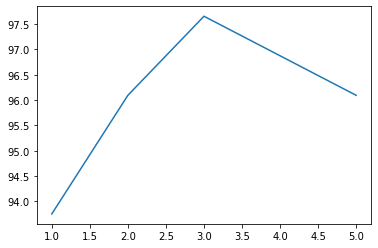

In [24]:
import matplotlib.pyplot as plt
EPOCHS = 5
torch.cuda.empty_cache()
model = BoWClassifier(vocab_size = len(vocab_words),
                      num_labels = 2)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.NLLLoss()
best_accuracy = 0
if using_GPU:
    model.cuda()
    loss_function.to('cuda')
accuracies=[]
for epoch in range(1, EPOCHS + 1):
    train_an_epoch(dataloader = train_dataloader,
                    model = model,
                    optimizer = optimizer, 
                    loss_fn=loss_function,
                    using_GPU = using_GPU)
    accuracy = get_accuracy(val_dataloader, model)
    if accuracy > best_accuracy:
            best_accuracy = accuracy
            with open("/content/drive/MyDrive/Repos/DepressionDetection/output/logistic_glove_NLTK_best.pt", 'wb') as f:
                torch.save(model, f)
                print("New best model saved!")
    
    accuracies.append(accuracy)
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

# TF - IDF

In [34]:
def collate_fn_tfidf(batch):
  tf_idf_matrix = torch.zeros(len(batch), tf_idf.shape[1])
  labels = []
  for i, (index, text, label) in enumerate(batch):
    tf_idf_matrix[i] = tf_idf[index]
    labels.append(label)
  return torch.tensor(labels).to("cuda"), tf_idf_matrix.to("cuda")

In [19]:
depression_data = dep_data(data_dir, pandas = True)

In [20]:
depression_data.split_data(123, pandas = True)

In [32]:
tf_idf, labels = create_tf_idf(depression_data.all_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [26]:
depression_data.train["class"] = depression_data.train["class"].map(LABEL_MAPPINGS)
depression_data.val["class"] = depression_data.val["class"].map(LABEL_MAPPINGS)

In [27]:
train_dataloader = DataLoader(depression_data.train.values.tolist(), batch_size=128,
                              shuffle=True, 
                              collate_fn=collate_fn_tfidf)
val_dataloader = DataLoader(depression_data.val.values.tolist(), batch_size=128,
                              shuffle=True, 
                              collate_fn=collate_fn_tfidf)

At iteration 500 the loss is 0.422.
At iteration 1000 the loss is 0.352.
New best model saved!

After epoch 1 the validation accuracy is 89.844.

At iteration 500 the loss is 0.260.
At iteration 1000 the loss is 0.277.
New best model saved!

After epoch 2 the validation accuracy is 93.750.

At iteration 500 the loss is 0.279.
At iteration 1000 the loss is 0.250.

After epoch 3 the validation accuracy is 92.188.

At iteration 500 the loss is 0.258.
At iteration 1000 the loss is 0.181.

After epoch 4 the validation accuracy is 89.844.

At iteration 500 the loss is 0.225.
At iteration 1000 the loss is 0.209.

After epoch 5 the validation accuracy is 90.625.



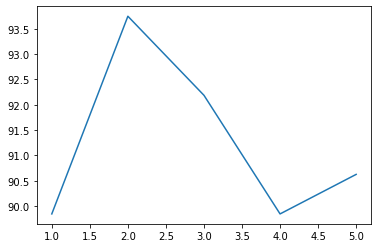

In [35]:
import matplotlib.pyplot as plt
EPOCHS = 5
using_GPU = True
torch.cuda.empty_cache()
model = BoWClassifier(vocab_size = tf_idf.shape[1],
                      num_labels = 2)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.NLLLoss()
best_accuracy = 0
if using_GPU:
    model.cuda()
    loss_function.to('cuda')
accuracies=[]
for epoch in range(1, EPOCHS + 1):
    train_an_epoch(dataloader = train_dataloader,
                    model = model,
                    optimizer = optimizer, 
                    loss_fn=loss_function,
                    using_GPU = using_GPU)
    accuracy = get_accuracy(val_dataloader, model)
    if accuracy > best_accuracy:
            best_accuracy = accuracy
            with open("/content/drive/MyDrive/Repos/DepressionDetection/output/logistic_tf_idf_best.pt", 'wb') as f:
                torch.save(model, f)
                print("New best model saved!")
    
    accuracies.append(accuracy)
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)